## Recurrent and Residual U-net

### Residual Network

* Residual networks were proposed to overcome the problems of `deep CNNs` (e.g., VGG)

* Stacking convolutional layers and making the model deeper makes a failure in `generalization` ability of the network. To address this issue, ResNet architecture was introduced which adds the idea of `skip connections`.

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/ResBlock.png" alt="ResNet" width="300"/>

Residual block from ResNet. Image by Wikipedia

* In traditional networks, each layer feeds into the `next layer`. In networks with residual blocks, each layer feeds into the next layer and directly into the layers about `2-3 hops away`.

<img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*Meth3XNFOEu6GH1s1sMUzw.png" alt="ResNet" width="400"/>

ref: https://medium.com/@Shahidul1004/yolov3-object-detection-f3090a24efcd

In the figure above, left block is the traditional network. Right one is residual network.

For residual network, we need to learn the function R(x) = f(x) - x.

`f(x) = R(x) + x`.

The residual block is trying to learn the output f(x). x is **identity function**. The layers are trying to learn the residual R(x).







### Recurrent Convolutional Network

* The recurrent network can use the feedback connection to store information over time

* Recurrent networks use context information; as time steps increase, the network leverages more and more neighborhood information.

(Recurrent and CNNs can be combined for image based applications)

* With Recurrent convolution layers, the network can evolve over time though the input is static.

<img src="https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/62ea835f8c07813a54bb0185_recurrent%20vs%20feedforward%20neural%20network%20.jpg" alt="ResNet" width="600"/>

https://www.v7labs.com/blog/recurrent-neural-networks-guide

* Each unit is influenced by its neighboring units, includes the context information of an image.

In [ ]:
# Sample attention block
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import backend as K

def attention_block(x, gating, inter_shape):
  shape_x = K.int_shape(x)  # x
  shape_g = K.int_shape(gating)  # g

  # Getting x to the same shape as gating signal (128 to 64)
  theta_x = layers.Conv2D(inter_shape, (2,2), strides=(2,2), padding='same')(x)
  shape_theta_x = K.int_shape(theta_x)

  # Getting the gating signal to the same number of filters as the inter_shape
  phi_g = layers.Conv2D(inter_shape, (1,1), padding='same')(gating)
  upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                      strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                      padding='same')(phi_g)  # 16

  concat_xg = layers.add([phi_g, theta_x])
  act_xg = layers.Activation('relu')(concat_xg)

  psi = layers.Conv2D(1, (1,1), padding='same')(act_xg)
  sigmoid_xg = layers.Activation('sigmoid')(psi)
  shape_sigmoid = K.int_shape(sigmoid_xg)

  upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)

  y = layers.multiply([upsample_psi, x])

  result = layers.Conv2D(shape_x[3], (1,1), padding='same')(y)
  result_bn = layers.BatchNormalization(result)

  return result_bn

### Dice Coefficient

Dice coefficient is a similarity metric commonly used in image segmentation. It also called the “`Sørensen–Dice` coefficient”.

Dice coefficient = **2 * |A ∩ B| / (|A| + |B|)**

Where `|A|` represents the `number of elements` in set A, and `|B|` represents the `number of elements` in set B. `|A ∩ B|` represents the number of elements that are present in `both sets`.

* It is particularly useful for imbalanced datasets, where one set may be much larger than the other.

* A `high Dice` coefficient value indicates a `high` level of `similarity` between the `predicted` and `ground truth masks`, meaning that the segmentation model or algorithm is `performing well`. Conversely, a low Dice coefficient value indicates poor segmentation performance.

Ex.

A = {1, 2, 3, 4, 5, 6} B = {1, 3, 5, 7, 9}

Dice coefficient = 2 * |A ∩ B| / (|A| + |B|) = 2 * 3 / (6 + 5) = 0.545

This means that sets A and B are 54.5% similar.


ref: [Dice Coefficient! What is it?](https://medium.com/@lathashreeh/dice-coefficient-what-is-it-ff090ec97bda#:~:text=The%20Dice%20coefficient%20is%20a,(%7CA%7C%20%2B%20%7CB%7C)



In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = layers.Flatten()(y_true)
    y_pred_f = layers.Flatten()(y_pred)
    intersection = tf.math.reduce_sum(y_true_f * y_pred_f)  # or tf.math.reduce_sum(x, axis=[0,1])
    #intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

### Jaccard Coefficient

The Jaccard Similarity can be used to compute the similarity between two `asymmetric binary variables`. Suppose a binary variable has only one of two states: `0` and `1`, where `0` means that the attribute is `absent`, and `1` means that it is `present`. While each state is equally valuable for symmetric binary attributes, the two states are not equally important in asymmetric binary variables.

Ex.

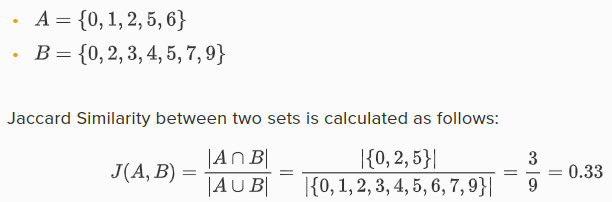


ref: [Jaccard Similarity](https://www.learndatasci.com/glossary/jaccard-similarity/)

In [ ]:
def jaccard_coef(y_true, y_pred):
    y_true_f = layers.Flatten()(y_true)
    y_pred_f = layers.Flatten()(y_pred)
    intersection = tf.math.reduce_sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.math.reduce_sum(y_true_f) + tf.math.reduce_sum(y_pred_f) - intersection + 1.0)

In [ ]:
def jaccard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

In [ ]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
        # (batch_size, height, width, channels): axis=3 -> channels
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [ ]:
def repeat_elem(tensor, rep):
    # lambda function to repeat the elements of a tensor along an axis by a
    # factor of rep. If tensor has shape (None, 256, 256, 3), lambda will return
    # a tensor of shape (None, 256,256,6), if specified axis=3 and rep=2.

    return layers.Lambda(lambda x, repnum: tf.repeat(x, repnum, axis=3),   # K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

In [ ]:
def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    There are two options for Residual convolutional layer.
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut - BN - shortcut + BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut - BN - shortcut + BN - Activation

    ref: https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf  (fig.4)
    '''

    # Conv2D - BN - Activation
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    # Conv2D - BN - Dropout
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    # Conv2D - BN  (for shortcut)
    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    # Activation after addition with shortcut (Original residual block)
    return res_path

### Reference

Original Paper: [Attention U-Net: Learning Where to Look for the Pancreas](https://arxiv.org/pdf/1804.03999.pdf)

[224 - Recurrent and Residual U-net](https://www.youtube.com/watch?v=7aDOtKN2cJs) by DigitalSreeni

[225 - Attention U-net. What is attention and why is it needed for U-Net? ](https://www.youtube.com/watch?v=KOF38xAvo8I) by DigitalSreeni

[226 - U-Net vs Attention U-Net vs Attention Residual U-Net - should you care? ](https://www.youtube.com/watch?v=L5iV5BHkMzM) by DigitalSreeni